## Predicting Stock Prices with Monte Carlo Simulations

In [1]:
!pip install -U --no-cache-dir backtesting pandas numpy rich httpx matplotlib pandas_ta lxml yfinance scipy -q

### Setting Up the Environment

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import concurrent.futures
import warnings
from rich.progress import track
from backtesting import Backtest, Strategy
import pandas_ta as ta
import matplotlib.pyplot as plt
from scipy.stats import norm
import httpx
import os
import backtesting

warnings.filterwarnings('ignore')

backtesting.set_bokeh_output(notebook=False)

FMP_API_KEY = "Q3jBkzf83C3TlvGThLCaT6xLSjO1cD1X" # os.environ.get('FMP_API_KEY')
FMP_BASE_URL = "https://financialmodelingprep.com/api/v3"

D:\WORKSPACE\GitHub\shortthirdman\DataScience-Jupyter-Notebooks\dev\Lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

### Defining Utility Functions

In [3]:
def make_api_request(api_endpoint, params):
    with httpx.Client() as client:
        # Make the GET request to the API
        response = client.get(api_endpoint, params=params)
        if response.status_code == 200:
            return response.json()
        print("Error: Failed to retrieve data from API")
        return None

def get_historical_price_full_crypto(symbol):
    api_endpoint = f"{FMP_BASE_URL}/historical-price-full/crypto/{symbol}"
    params = {"apikey": FMP_API_KEY}
    return make_api_request(api_endpoint, params)


def get_historical_price_full_stock(symbol):
    api_endpoint = f"{FMP_BASE_URL}/historical-price-full/{symbol}"
    params = {"apikey": FMP_API_KEY}

    return make_api_request(api_endpoint, params)

def get_SP500():
    api_endpoint = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    data = pd.read_html(api_endpoint)
    return list(data[0]['Symbol'])

def get_all_crypto():
    return [
        "BTCUSD", "ETHUSD", "LTCUSD", "BCHUSD", "XRPUSD", "EOSUSD",
        "XLMUSD", "TRXUSD", "ETCUSD", "DASHUSD", "ZECUSD", "XTZUSD",
        "XMRUSD", "ADAUSD", "NEOUSD", "XEMUSD", "VETUSD", "DOGEUSD",
        "OMGUSD", "ZRXUSD", "BATUSD", "USDTUSD", "LINKUSD", "BTTUSD",
        "BNBUSD", "ONTUSD", "QTUMUSD", "ALGOUSD", "ZILUSD", "ICXUSD",
        "KNCUSD", "ZENUSD", "THETAUSD", "IOSTUSD", "ATOMUSD", "MKRUSD",
        "COMPUSD", "YFIUSD", "SUSHIUSD", "SNXUSD", "UMAUSD", "BALUSD",
        "AAVEUSD", "UNIUSD", "RENBTCUSD", "RENUSD", "CRVUSD", "SXPUSD",
        "KSMUSD", "OXTUSD", "DGBUSD", "LRCUSD", "WAVESUSD", "NMRUSD",
        "STORJUSD", "KAVAUSD", "RLCUSD", "BANDUSD", "SCUSD", "ENJUSD",
    ]

def get_financial_statements_lists():
    api_endpoint = f"{FMP_BASE_URL}/financial-statement-symbol-lists"
    params = {"apikey": FMP_API_KEY}
    return make_api_request(api_endpoint, params)

### Splitting Data into Training and Testing Sets

In [4]:
stock_symbol = "AAPL"
stock_prices = get_historical_price_full_stock(stock_symbol)

if stock_prices is not None:
    data = pd.DataFrame(stock_prices['historical'])
else:
    raise RuntimeError('Could not load stock prices')

data.head(5)

data.tail(5)

# Splitting the data
january_2023_index = data[(data['date'] < '2023-01-01')].index
prices_before_january_2023 = data[(data['date'] < '2023-01-01')]
prices_after_january_2023 = data.drop(january_2023_index)

# Assuming prices_after_january_2023 is your DataFrame
prices_after_january_2023 = prices_after_january_2023.rename(columns={
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'  # Only if you have a volume column
})

# Drop any additional columns that are not required
required_columns = ['date', 'Open', 'High', 'Low', 'Close', 'Volume']
prices_after_january_2023 = prices_after_january_2023[required_columns]

# sort by date ascending
prices_after_january_2023 = prices_after_january_2023.sort_values(by=['date'], ascending=True)

In [5]:
print("Index for Jan 2023")
print(january_2023_index)

print("Prices before Jan 2023")
prices_before_january_2023.head(5)

print("Prices after Jan 2023")
prices_after_january_2023.head(5)

Index for Jan 2023
Index([ 361,  362,  363,  364,  365,  366,  367,  368,  369,  370,
       ...
       1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258],
      dtype='int64', length=898)
Prices before Jan 2023
Prices after Jan 2023


,date,Open,High,Low,Close,Volume
360,2023-01-03,130.28,130.90,124.17,125.07,112117471
359,2023-01-04,126.89,128.66,125.08,126.36,89113633
358,2023-01-05,127.13,127.77,124.76,125.02,80962708
357,2023-01-06,126.01,130.29,124.89,129.62,87754715
356,2023-01-09,130.47,133.41,129.89,130.15,70790813


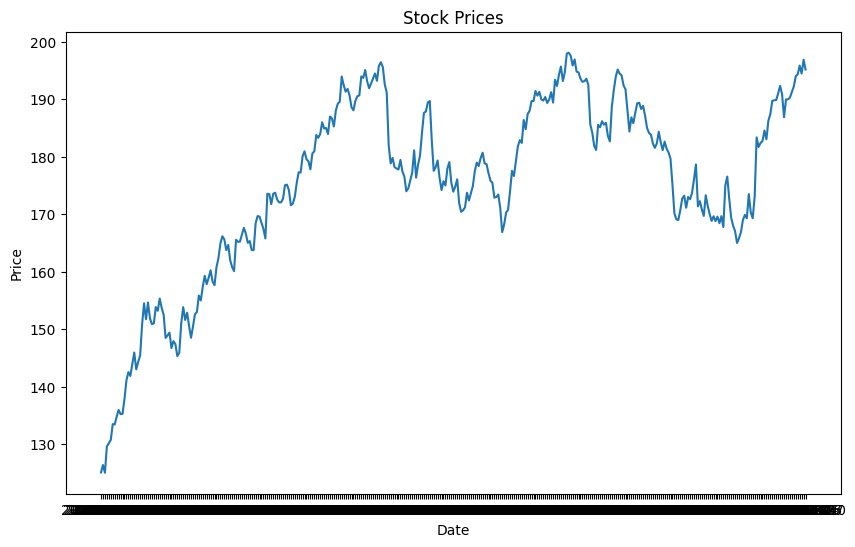

In [6]:
plt.figure(figsize=(10, 6))
plt.title('Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
# if (prices_before_january_2023 is not None) and (not prices_before_january_2023.empty):
#     plt.plot(prices_before_january_2023['date'], prices_before_january_2023['Close'])
plt.plot(prices_after_january_2023['date'], prices_after_january_2023['Close'])
plt.show()

### Applying Monte Carlo Simulation

In [7]:
def monte_carlo_simulation(data, days, iterations):
    if isinstance(data, pd.Series):
        data = data.to_numpy()
    if not isinstance(data, np.ndarray):
        raise TypeError("Data must be a numpy array or pandas Series")

    log_returns = np.log(data[1:] / data[:-1])
    mean = np.mean(log_returns)
    variance = np.var(log_returns)
    drift = mean - (0.5 * variance)
    daily_volatility = np.std(log_returns)

    future_prices = np.zeros((days, iterations))
    current_price = data[-1]
    for t in range(days):
        shocks = drift + daily_volatility * norm.ppf(np.random.rand(iterations))
        future_prices[t] = current_price * np.exp(shocks)
        current_price = future_prices[t]
    return future_prices

### Visualization

Average future price after 364 days: $306.40
Date of simulation: 2025-06-09
Real price on 2024-05-14: $187.43
Price difference: $118.97
Price difference percentage: 63.48%
Model accuracy: 36.52%


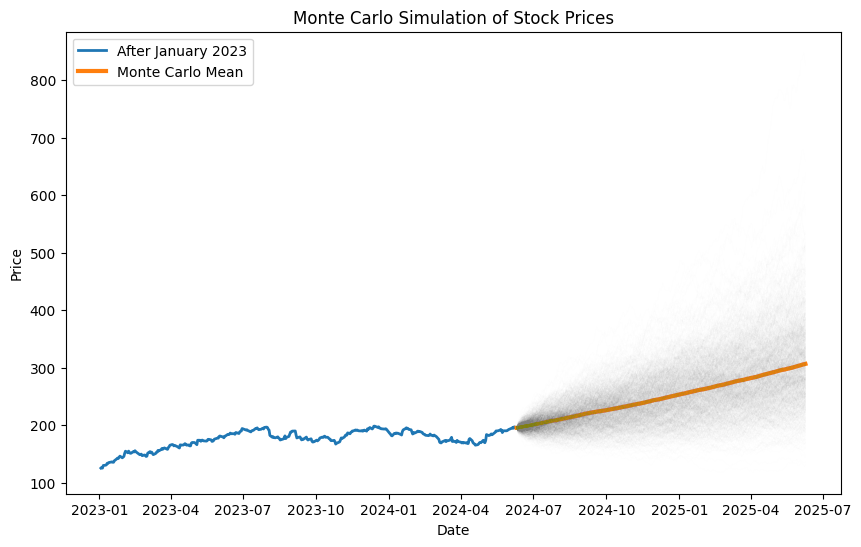

In [8]:
simulation_days = 364
mc_iterations = 1000
mc_prices = monte_carlo_simulation(prices_after_january_2023['Close'], simulation_days, mc_iterations)

# Last closing price repeated for each iteration
last_close_price = np.full((1, mc_iterations), prices_after_january_2023['Close'].iloc[-1])

# Combine the last closing price with the Monte Carlo simulation prices
mc_prices_combined = np.concatenate((last_close_price, mc_prices), axis=0)

# Adjust the periods in the date range to match the number of rows in mc_prices_combined
last_date = prices_after_january_2023['date'].iloc[-1]
simulated_dates = pd.date_range(start=last_date, periods=simulation_days + 1)

# Visualizing the Monte Carlo simulation alongside historical data
plt.figure(figsize=(10, 6))

# Plot historical data
#plt.plot(pd.to_datetime(prices_before_january_2023['date']), prices_before_january_2023['Close'], label='Before January 2023', linewidth=2)
plt.plot(pd.to_datetime(prices_after_january_2023['date']), prices_after_january_2023['Close'], label='After January 2023', linewidth=2)

# Taking average of all simulations on the 365th day
future_price_mcmc = np.mean(mc_prices_combined[364, :])
print(f"Average future price after 364 days: ${future_price_mcmc:.2f}")
print(f"Date of simulation: {simulated_dates[364].date()}")
simulated_date = simulated_dates[364].date()
real_price = prices_after_january_2023['Close'][18]
real_date = prices_after_january_2023['date'][18]
print(f"Real price on {real_date}: ${real_price:.2f}")
print(f"Price difference: ${future_price_mcmc - real_price:.2f}")
print(f"Price difference percentage: {(future_price_mcmc - real_price) / real_price * 100:.2f}%")
print(f"Model accuracy: {100 - abs((future_price_mcmc - real_price) / real_price * 100):.2f}%")

# Plot Monte Carlo simulations mean
plt.plot(simulated_dates, mc_prices_combined.mean(axis=1), label='Monte Carlo Mean', linewidth=3)

# Plot each simulation path
for i in range(mc_iterations):
    plt.plot(simulated_dates, mc_prices_combined[:, i], linewidth=0.5, color='gray', alpha=0.01)

plt.title('Monte Carlo Simulation of Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()